<a href="https://colab.research.google.com/github/mdunand2/2024_MLEES/blob/main/Project/Landslide_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import rainfall data from Italy

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Downloading the necessary libraries

In [2]:
pip install pandas

In [3]:
import pandas as pd

# Provide access to google drive for direct data retrieval
from google.colab import drive
drive.mount('/content/drive')

# Import files with rainfall events that triggered shallow landslides (SL)
with_SL = pd.read_csv('/content/drive/MyDrive/si_12.csv', sep = ';')
# Import files with rainfall events that didn't trigger shallow landslides (SL)
without_SL = pd.read_csv('/content/drive/MyDrive/no_12_subsamp.csv', sep = ';')

Mounted at /content/drive


Let's see if our two databases have been imported correctly

In [4]:
print("Rainfall events that triggered SL :")
with_SL.head()

Rainfall events that triggered SL :


,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,18,38.8,12,17.0,1,4265480137173,227,N_0084,2008-06-09 16:00:00,2008,6,9,1,789.9,68,*,*
1,16,12.6,12,75.6,1,4265480137173,412,N_0185,2013-11-11 22:00:00,2013,11,11,2,789.9,68,*,*
2,38,84.4,12,13.8,1,4272970136917,130,N_5311,2012-07-24 09:00:00,2012,7,24,0,422.0,42,*,*
3,35,43.2,12,0.0,1,4272970136917,147,N_5416,2013-05-12 10:00:00,2013,5,12,1,422.0,42,*,*
4,49,42.8,12,41.8,1,4275720136456,97,N_3296,2009-04-21 21:00:00,2009,4,21,2,487.1,44,*,*


In [5]:
print("Rainfall events that didn't triggered SL :")
without_SL.head()

Rainfall events that didn't triggered SL :


,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,68,18.6,12,0.0,0,4423720105164,220,no_frana,2010-01-18 10:00:00,2010,1,18,1,1530.2,94,*,*
1,152,15.6,12,0.0,0,3797270142892,147,no_frana,2006-12-25 00:00:00,2006,12,25,0,683.3,67,*,*
2,3,11.6,12,1.2,0,4581190098661,21,no_frana,2012-07-06 22:00:00,2012,7,6,2,1277.1,85,*,*
3,49,90.0,12,12.8,0,4531530075472,307,no_frana,2010-11-02 07:00:00,2010,11,2,0,1287.4,78,*,*
4,22,34.6,12,5.4,0,4612990123183,7,no_frana,2002-04-17 05:00:00,2002,4,17,0,1263.8,81,*,*


Now that our two databases have been correctly imported, it's important to prepare the data. To start with, we're going to merge these two tables into one.

In [6]:
# Concatenate the two DataFrames
total_SL = pd.concat([with_SL, without_SL], ignore_index=True)

# Display the merged DataFrame
total_SL

,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,18,38.8,12,17.0,1,4265480137173,227,N_0084,2008-06-09 16:00:00,2008,6,9,1,789.9,68,*,*
1,16,12.6,12,75.6,1,4265480137173,412,N_0185,2013-11-11 22:00:00,2013,11,11,2,789.9,68,*,*
2,38,84.4,12,13.8,1,4272970136917,130,N_5311,2012-07-24 09:00:00,2012,7,24,0,422.0,42,*,*
3,35,43.2,12,0.0,1,4272970136917,147,N_5416,2013-05-12 10:00:00,2013,5,12,1,422.0,42,*,*
4,49,42.8,12,41.8,1,4275720136456,97,N_3296,2009-04-21 21:00:00,2009,4,21,2,487.1,44,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,71,5.2,12,3.6,0,4452940104894,32,no_frana,2002-12-28 18:00:00,2002,12,28,1,650.2,61,*,*
4584,62,12.0,12,7.8,0,4382040104132,121,no_frana,2006-03-24 17:00:00,2006,3,24,1,968.8,68,*,*
4585,3,3.4,12,2.8,0,4412000118081,109,no_frana,2010-04-13 12:00:00,2010,4,13,1,549.2,52,*,*
4586,14,10.2,12,0.0,0,3825700155604,53,no_frana,2004-02-17 02:00:00,2004,2,17,0,915.6,78,*,*


It is necessary to prepare the data so as to keep only those variables that really interest us for this project.

*   Dnl : Antecedent period of the rainfall
*   Cnl : Cumulated intensity during the antecedent period
*   Dl : Triggering period of the rainfall
*   Cl : Cumulated intensity during the triggering period
*   bit_lan : If the rainfall, triggered a shallow landslide (SL), bit_lan = 1, and if not bit_lan = 0
*   date : Date and time of the beginning of the rainfall (à contrôler)

In [7]:
 # Select the columns that are important for the project
selected_SL = total_SL.iloc[:, [0, 1, 3, 4, 8]]

selected_SL.head()

,Dnl,Cnl,Cl,bit_lan,date
0,18,38.8,17.0,1,2008-06-09 16:00:00
1,16,12.6,75.6,1,2013-11-11 22:00:00
2,38,84.4,13.8,1,2012-07-24 09:00:00
3,35,43.2,0.0,1,2013-05-12 10:00:00
4,49,42.8,41.8,1,2009-04-21 21:00:00


The data will be divided into training, test and validation sets.

In [8]:
from sklearn.model_selection import train_test_split

# Separate the data into two groups: with landslides (bit_lan=1) and without landslides (bit_lan=0)
with_landslide = selected_SL[selected_SL['bit_lan'] == 1]
without_landslide = selected_SL[selected_SL['bit_lan'] == 0]


# 1. Divide each group into training/validation data (80%) and test data (20%)
with_landslide_train_val, with_landslide_test = train_test_split(with_landslide, test_size=0.2, random_state=42)
without_landslide_train_val, without_landslide_test = train_test_split(without_landslide, test_size=0.2, random_state=42)

# 2. Divide the training/validation package (80%) between training (64%) and validation (16%)
with_landslide_train, with_landslide_val = train_test_split(with_landslide_train_val, test_size=0.2, random_state=42)
without_landslide_train, without_landslide_val = train_test_split(without_landslide_train_val, test_size=0.2, random_state=42)

# 3. Combine training, validation and test data for the two classes (with and without landslides)
train_df = pd.concat([with_landslide_train, without_landslide_train], ignore_index=True)
val_df = pd.concat([with_landslide_val, without_landslide_val], ignore_index=True)
test_df = pd.concat([with_landslide_test, without_landslide_test], ignore_index=True)

# Afficher la taille des ensembles pour vérification
print(f"Size training set : {train_df.shape[0]}")
print(f"Size validation set : {val_df.shape[0]}")
print(f"Size test set : {test_df.shape[0]}")


Size training set : 2936
Size validation set : 734
Size test set : 918


It is still necessary to create the matrix X and y, X being the exponential variables, i.e. Dnl, Cnl, Cl, and y the target values, i.e. bit_lan. for training, test and validation

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Prepare the explanatory variables and the target variable
# The explanatory columns are Dnl, Cnl, Cl and the target variable is bit_lan

# For the training set
X_train = train_df[['Dnl', 'Cnl', 'Cl']]
y_train = train_df['bit_lan']

# For the validation set
X_val = val_df[['Dnl', 'Cnl', 'Cl']]
y_val = val_df['bit_lan']

# For the test set
X_test = test_df[['Dnl', 'Cnl', 'Cl']]
y_test = test_df['bit_lan']

In [10]:
# 2. Initialiser le modèle Random Forest
# Vous pouvez ajuster le nombre d'arbres avec le paramètre n_estimators et d'autres hyperparamètres si nécessaire
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [11]:
# 3. Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# 4. Évaluer le modèle

# Prédictions sur l'ensemble de validation
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Précision sur l'ensemble de validation : {val_accuracy:.4f}")

# Prédictions sur l'ensemble de test
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Précision sur l'ensemble de test : {test_accuracy:.4f}")

# Rapport de classification pour l'ensemble de test
print("\nRapport de classification pour l'ensemble de test :")
print(classification_report(y_test, y_test_pred))

# Matrice de confusion pour l'ensemble de test
print("\nMatrice de confusion pour l'ensemble de test :")
print(confusion_matrix(y_test, y_test_pred))

Précision sur l'ensemble de validation : 0.8011
Précision sur l'ensemble de test : 0.8105

Rapport de classification pour l'ensemble de test :
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       459
           1       0.82      0.80      0.81       459

    accuracy                           0.81       918
   macro avg       0.81      0.81      0.81       918
weighted avg       0.81      0.81      0.81       918


Matrice de confusion pour l'ensemble de test :
[[376  83]
 [ 91 368]]


In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 1. Définir les paramètres et leurs valeurs possibles pour la recherche
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],        # Nombre d'arbres
    'max_depth': [None, 10, 20, 30, 40, 50],          # Profondeur maximale de chaque arbre
    'min_samples_split': [2, 5, 10],                  # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],                    # Nombre minimum d'échantillons dans une feuille
    'max_features': ['sqrt', 'log2'],         # Nombre maximum de caractéristiques à considérer pour chaque split
    'bootstrap': [True, False]                        # Méthode de rééchantillonnage
}

# 2. Initialiser le modèle Random Forest
model = RandomForestClassifier(random_state=42)

# 3. Configurer RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,                   # Nombre de combinaisons testées (plus élevé = plus de précision mais plus de temps)
    scoring='accuracy',          # Critère d'évaluation
    cv=5,                        # Validation croisée à 5 plis
    random_state=42,
    n_jobs=-1                    # Utiliser tous les cœurs du processeur
)

# 4. Lancer la recherche aléatoire sur l'ensemble d'entraînement
random_search.fit(X_train, y_train)

# 5. Afficher les meilleurs hyperparamètres trouvés et la précision correspondante
print("Meilleurs hyperparamètres : ", random_search.best_params_)
print("Précision avec les meilleurs paramètres : ", random_search.best_score_)


Meilleurs hyperparamètres :  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Précision avec les meilleurs paramètres :  0.825272050898724


In [14]:
# Obtenez le meilleur modèle trouvé par RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Évaluez le modèle sur l'ensemble de test pour obtenir la précision finale
test_accuracy = best_rf_model.score(X_test, y_test)
print("Précision sur l'ensemble de test avec le modèle optimisé :", test_accuracy)

Précision sur l'ensemble de test avec le modèle optimisé : 0.8159041394335512


Maintenant que les meilleurs paramètres ont été trouvés, on va réentraîner notre modèle avec ces paramètres.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Créer un nouveau modèle Random Forest avec les meilleurs hyperparamètres trouvés
best_params = random_search.best_params_
final_model = RandomForestClassifier(**best_params, random_state=42)

# 2. Entraîner le modèle final sur l'ensemble d'entraînement
final_model.fit(X_train, y_train)

# 3. Évaluer le modèle sur l'ensemble de validation
y_val_pred = final_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Précision sur l'ensemble de validation avec le modèle final : {val_accuracy:.4f}")

# 4. Évaluer le modèle sur l'ensemble de test
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Précision sur l'ensemble de test avec le modèle final : {test_accuracy:.4f}")

# Afficher le rapport de classification pour des mesures plus détaillées
print("\nRapport de classification pour l'ensemble de test :")
print(classification_report(y_test, y_test_pred))

# Afficher la matrice de confusion pour l'ensemble de test
print("\nMatrice de confusion pour l'ensemble de test :")
print(confusion_matrix(y_test, y_test_pred))

Précision sur l'ensemble de validation avec le modèle final : 0.8052
Précision sur l'ensemble de test avec le modèle final : 0.8159

Rapport de classification pour l'ensemble de test :
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       459
           1       0.81      0.82      0.82       459

    accuracy                           0.82       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.82      0.82      0.82       918


Matrice de confusion pour l'ensemble de test :
[[372  87]
 [ 82 377]]


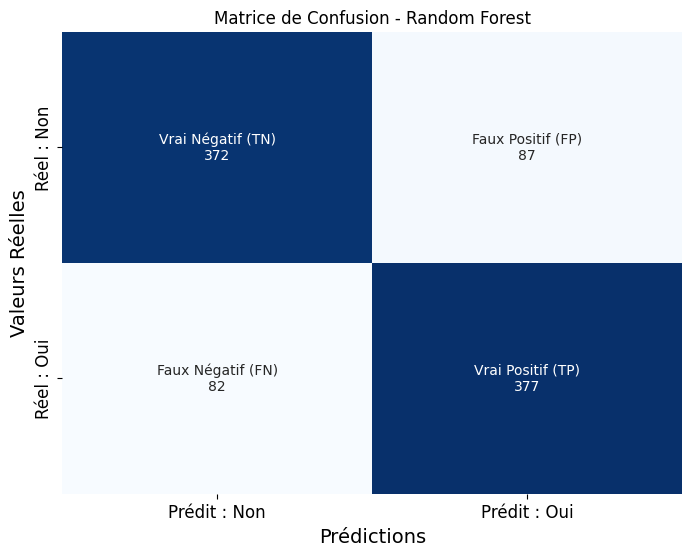

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Définir les étiquettes pour chaque case (Vrai Positif, Faux Positif, etc.)
labels = ['Vrai Négatif (TN)', 'Faux Positif (FP)', 'Faux Négatif (FN)', 'Vrai Positif (TP)']
label_counts = [f"{label}\n{value}" for label, value in zip(labels, conf_matrix.flatten())]
label_counts = np.array(label_counts).reshape(2, 2)

# Tracer la matrice de confusion avec des annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=label_counts, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Prédit : Non', 'Prédit : Oui'],
            yticklabels=['Réel : Non', 'Réel : Oui'])

plt.title("Matrice de Confusion - Random Forest")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs Réelles")
plt.show()


In [17]:
# Extraire l'importance des variables
importances = final_model.feature_importances_

# Obtenir les noms des variables (colonnes utilisées pour l'entraînement)
feature_names = X_train.columns  # Remplacer X_train.columns par une liste si les colonnes n'ont pas de nom dans le DataFrame

# Associer chaque nom de variable à son importance
feature_importances = pd.DataFrame({'Variable': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

  Variable  Importance
2       Cl    0.551568
1      Cnl    0.294656
0      Dnl    0.153776


<ipython-input-18-e6883a0cd219>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable', data=feature_importances, palette='viridis')


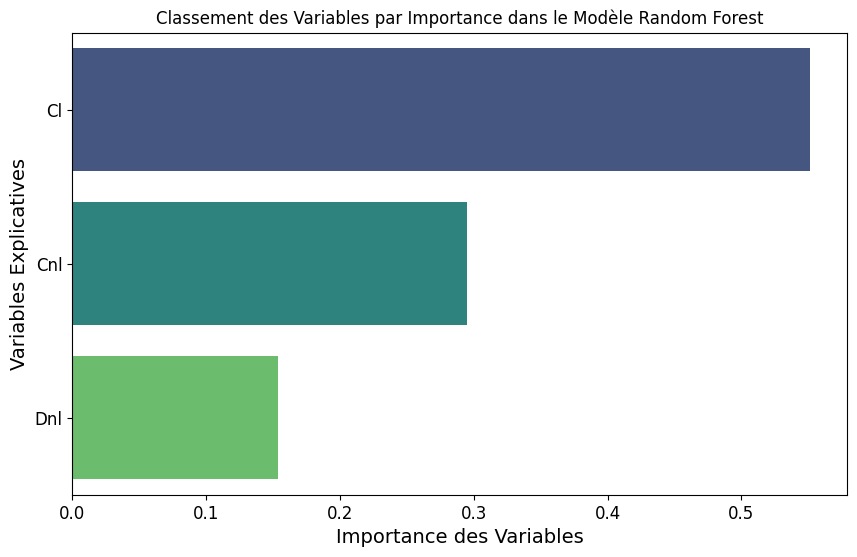

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tracer un graphique en barres de l'importance des variables
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=feature_importances, palette='viridis')
plt.title("Classement des Variables par Importance dans le Modèle Random Forest")
plt.xlabel("Importance des Variables")
plt.ylabel("Variables Explicatives")
plt.show()

Aire sous la courbe ROC (AUC) : 0.90


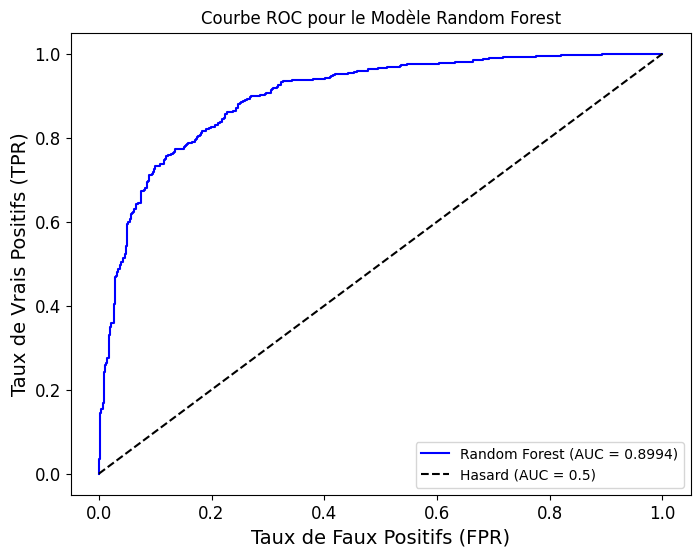

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculer les probabilités pour la classe positive (glissement de terrain)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

# Calculer les valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Calculer l'AUC
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Aire sous la courbe ROC (AUC) : {auc_score:.2f}")

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Hasard (AUC = 0.5)")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC pour le Modèle Random Forest")
plt.legend(loc="lower right")
plt.show()


Maintenant, je vais tester un modèle XGBoost pour pouvoir le comparer à Random Forest. Commençons par installer XGBoost dans notre environnement.

In [20]:
!pip install xgboost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Précision sur l'ensemble de validation (XGBoost) : 0.8025
Précision sur l'ensemble de test (XGBoost) : 0.8017

Rapport de classification (XGBoost) :
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       459
           1       0.80      0.80      0.80       459

    accuracy                           0.80       918
   macro avg       0.80      0.80      0.80       918
weighted avg       0.80      0.80      0.80       918



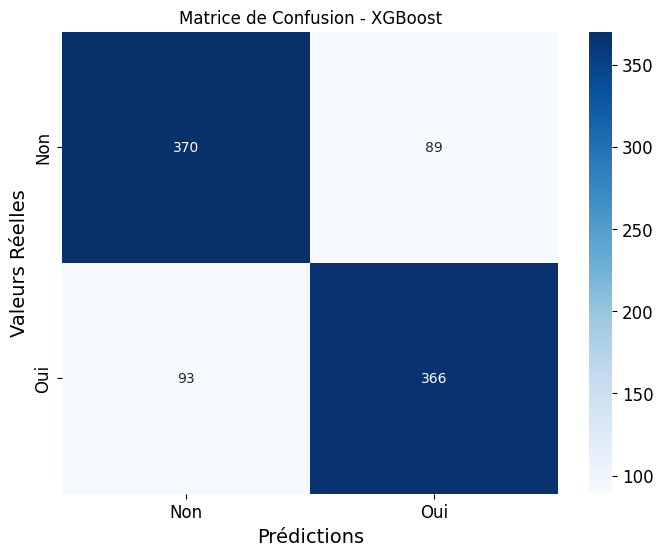

In [21]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un modèle XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Entraîner le modèle sur l'ensemble de données d'entraînement
xgb_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
y_val_pred = xgb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Précision sur l'ensemble de validation (XGBoost) : {val_accuracy:.4f}")

# Prédictions sur l'ensemble de test
y_test_pred = xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Précision sur l'ensemble de test (XGBoost) : {test_accuracy:.4f}")

# Afficher le rapport de classification pour des mesures détaillées
print("\nRapport de classification (XGBoost) :")
print(classification_report(y_test, y_test_pred))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non", "Oui"], yticklabels=["Non", "Oui"])
plt.title("Matrice de Confusion - XGBoost")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs Réelles")
plt.show()


Aire sous la courbe ROC (AUC) pour XGBoost : 0.8917


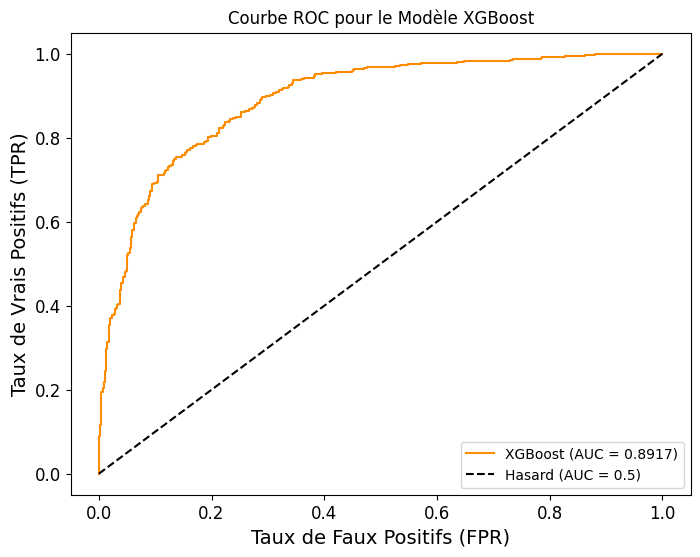

In [22]:
# Calculer les probabilités pour la classe positive
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculer les valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Calculer l'AUC
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Aire sous la courbe ROC (AUC) pour XGBoost : {auc_score:.4f}")

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Hasard (AUC = 0.5)")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC pour le Modèle XGBoost")
plt.legend(loc="lower right")
plt.show()


Je vais tout de même essayer d'optimiser mon modèle pour voir s'il est possible d'avoir un meilleur résultat qu'avec random forest

In [23]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Définir l'espace de recherche pour les hyperparamètres
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7]
}

# Créer le modèle XGBoost de base
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # nombre d'itérations de recherche aléatoire
    scoring='roc_auc',  # utiliser l'AUC comme score d'évaluation
    cv=3,  # validation croisée à 3 sous-échantillons
    verbose=1,
    random_state=42,
    n_jobs=-1  # utiliser tous les cœurs disponibles pour accélérer la recherche
)

# Lancer RandomizedSearchCV
random_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et la meilleure performance AUC
print("Meilleurs hyperparamètres :", random_search.best_params_)
print("Meilleur score AUC avec les meilleurs hyperparamètres :", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs hyperparamètres : {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.001, 'gamma': 0.2, 'colsample_bytree': 1.0}
Meilleur score AUC avec les meilleurs hyperparamètres : 0.9014496318389685


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [24]:
# Récupérer les meilleurs hyperparamètres
best_params = random_search.best_params_

# Créer un modèle XGBoost avec les meilleurs hyperparamètres
best_xgb_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Entraîner le modèle sur l'ensemble de données d'entraînement
best_xgb_model.fit(X_train, y_train)

# Évaluer la performance du modèle sur l'ensemble de validation
y_val_pred = best_xgb_model.predict(X_val)
y_val_proba = best_xgb_model.predict_proba(X_val)[:, 1]
val_accuracy = accuracy_score(y_val, y_val_pred)
val_auc_score = roc_auc_score(y_val, y_val_proba)

# Évaluer la performance du modèle sur l'ensemble de test
y_test_pred = best_xgb_model.predict(X_test)
y_test_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculer l'AUC et afficher la précision
auc_score = roc_auc_score(y_test, y_test_proba)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Précision sur l'ensemble de validation avec les meilleurs hyperparamètres (XGBoost) : {val_accuracy:.4f}")
print(f"Aire sous la courbe ROC (AUC) sur l'ensemble de validation : {val_auc_score:.4f}")
print(f"Précision sur l'ensemble de test avec les meilleurs hyperparamètres (XGBoost) : {test_accuracy:.2f}")
print(f"Aire sous la courbe ROC (AUC) sur l'ensemble de test : {auc_score:.2f}")


Précision sur l'ensemble de validation avec les meilleurs hyperparamètres (XGBoost) : 0.8011
Aire sous la courbe ROC (AUC) sur l'ensemble de validation : 0.8847
Précision sur l'ensemble de test avec les meilleurs hyperparamètres (XGBoost) : 0.82
Aire sous la courbe ROC (AUC) sur l'ensemble de test : 0.90


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


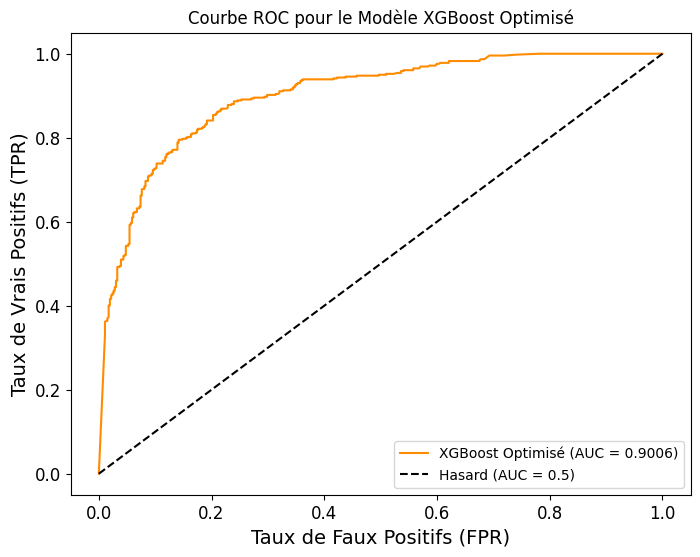

In [25]:
# Calculer la courbe ROC pour le modèle optimisé
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost Optimisé (AUC = {auc_score:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Hasard (AUC = 0.5)")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC pour le Modèle XGBoost Optimisé")
plt.legend(loc="lower right")
plt.show()


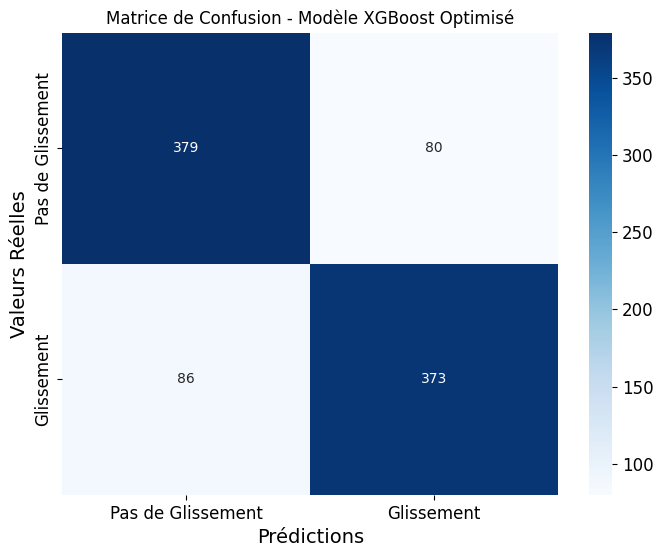

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions sur l'ensemble de test avec le modèle optimisé
y_test_pred = best_xgb_model.predict(X_test)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Afficher la matrice de confusion avec des annotations pour une lecture plus facile
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pas de Glissement", "Glissement"],
            yticklabels=["Pas de Glissement", "Glissement"])
plt.title("Matrice de Confusion - Modèle XGBoost Optimisé")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs Réelles")
plt.show()

In [27]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Configuration du modèle XGBoost avec les meilleurs paramètres
xgb_model_early_stopping = xgb.XGBClassifier(**best_params, eval_metric="auc", early_stopping_rounds=10)

# Entraînement avec early stopping
xgb_model_early_stopping.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Ensemble de validation pour l'early stopping
    verbose=True                    # Affiche les résultats à chaque itération
)

# Prédictions sur l'ensemble de test avec le modèle optimisé et early stopping
y_test_pred = xgb_model_early_stopping.predict(X_test)

# Calcul de la précision pour évaluer les performances sur le test
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Précision sur l'ensemble de test : {accuracy:.4f}")


[0]	validation_0-auc:0.86857
[1]	validation_0-auc:0.87993
[2]	validation_0-auc:0.88004
[3]	validation_0-auc:0.88026
[4]	validation_0-auc:0.88090
[5]	validation_0-auc:0.88341
[6]	validation_0-auc:0.88282
[7]	validation_0-auc:0.88345
[8]	validation_0-auc:0.88403
[9]	validation_0-auc:0.88343
[10]	validation_0-auc:0.88289
[11]	validation_0-auc:0.88244
[12]	validation_0-auc:0.88257
[13]	validation_0-auc:0.88246
[14]	validation_0-auc:0.88234
[15]	validation_0-auc:0.88209
[16]	validation_0-auc:0.88272
[17]	validation_0-auc:0.88245
Précision sur l'ensemble de test : 0.8203


Je suis pas trop sûre que le truc de early stopping ait fonctionné mais je le laisse là au cas où.

In [28]:
from xgboost import cv
import xgboost as xgb

# Définir les paramètres du modèle avec les meilleurs paramètres trouvés
params = best_params
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'
params['seed'] = 42

# Effectuer la validation croisée
xgb_cv = xgb.cv(
    params=params,
    dtrain=xgb.DMatrix(X_train, label=y_train),
    nfold=5,  # Diviser en 5 sous-échantillons
    num_boost_round=200,  # Nombre de tours maximum
    early_stopping_rounds=10,
    metrics="auc",
    as_pandas=True,
    seed=42
)

# Afficher les scores de validation croisée
print(xgb_cv)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.904480       0.003066       0.884381      0.009760
1         0.911339       0.002427       0.889621      0.010639
2         0.913933       0.002007       0.890529      0.011756
3         0.915290       0.002069       0.892216      0.011444
4         0.915971       0.001895       0.893667      0.012625
5         0.916525       0.001920       0.894238      0.012036
6         0.917099       0.002067       0.895037      0.011962
7         0.917184       0.002047       0.894857      0.011577
8         0.917465       0.001906       0.895177      0.011212
9         0.917507       0.001970       0.895498      0.010914
10        0.917594       0.001975       0.895244      0.010301
11        0.917799       0.001990       0.895867      0.010256
12        0.918019       0.001991       0.896058      0.009971
13        0.918108       0.001958       0.896205      0.009794
14        0.918191       0.001803       0.895993      0

In [29]:
# Combine les données d'entraînement et de validation
X_train_full = pd.concat([X_train, X_val], axis=0)  # Combine les caractéristiques
y_train_full = pd.concat([y_train, y_val], axis=0)  # Combine les étiquettes

In [30]:
# Enlever 'n_estimators' de best_params s'il est déjà défini
best_params.pop('n_estimators', None)
best_params.pop('eval_metric', None)

# Entraînement final avec le nombre optimal de rounds trouvé avec la cross-validation
best_num_rounds = len(xgb_cv)  # Cela vous donne le nombre optimal de rounds basé sur la cv
xgb_final_model = xgb.XGBClassifier(
    **best_params,
    n_estimators=best_num_rounds,
    eval_metric="auc"
)

# Entraîner le modèle final sur l'ensemble complet d'entraînement et de validation
xgb_final_model.fit(X_train_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=38, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
# Faire des prédictions sur l'ensemble de test
y_pred = xgb_final_model.predict(X_test)
y_pred_proba = xgb_final_model.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive (1)


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculer les métriques de classification
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.8159
Precision: 0.8222
Recall: 0.8061
F1 Score: 0.8141


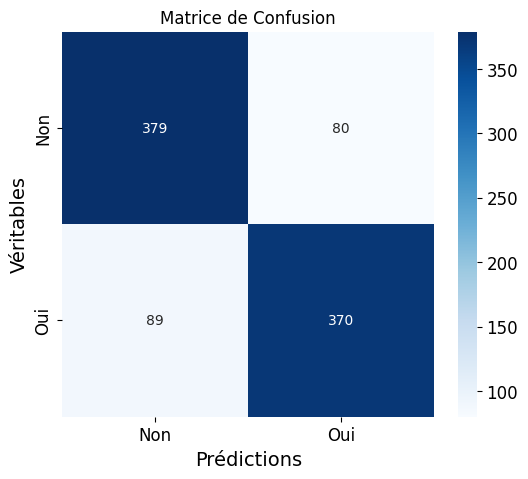

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de tableau avec des annotations
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()


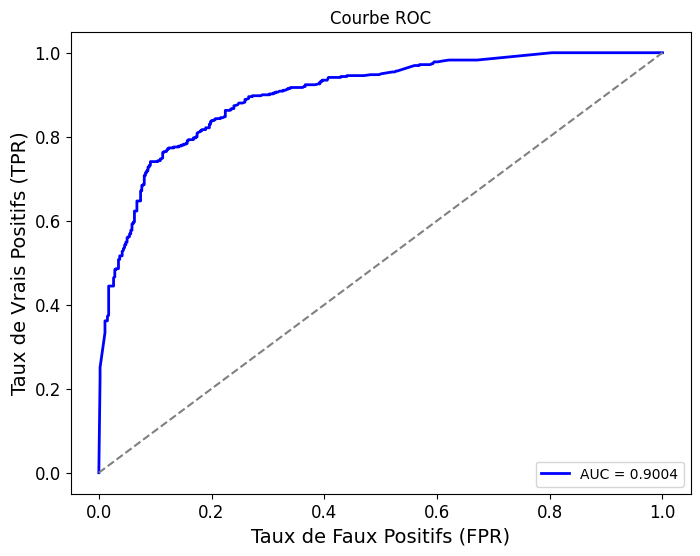

In [34]:
from sklearn.metrics import roc_curve, auc

# Calculer les faux positifs, vrais positifs et seuils
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculer l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de référence (auc = 0.5)
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


Je fais l'importance des variables par rapport au modèle optimisé XGBoost et non celui avec early stopping ou celui avec cross validation

  Feature  Importance (%)
2      Cl       73.430214
1     Cnl       22.415083
0     Dnl        4.154703


Text(0.5, 1.0, 'Importance des Variables')

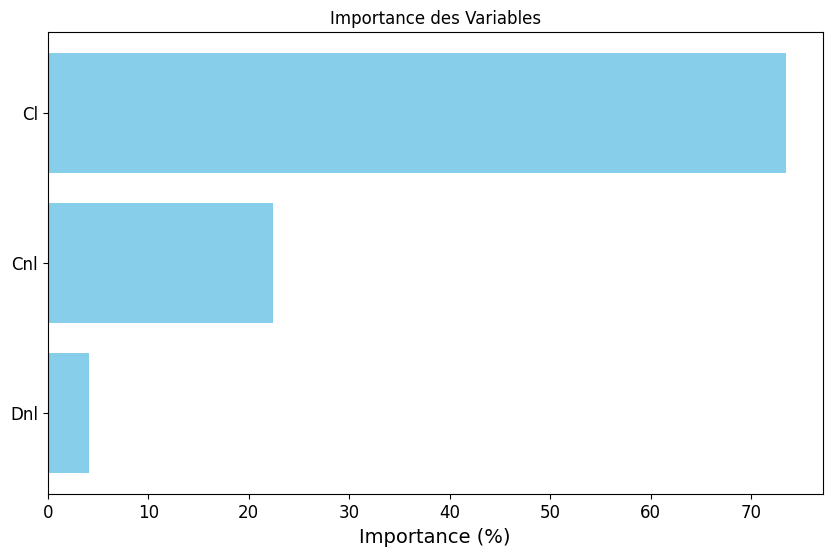

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraire l'importance des variables
importance = best_xgb_model.feature_importances_

# Convertir en pourcentage
importance_percentage = 100 * (importance / importance.sum())

# Créer un DataFrame pour faciliter la visualisation
features = X_train.columns  # Utiliser les noms des colonnes d'origine
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance (%)': importance_percentage
}).sort_values(by='Importance (%)', ascending=False)

# Affichage de l'importance des variables
print(feature_importance_df)

# Tracer un graphique à barres pour l'importance des variables
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance (%)'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'axe y pour que les plus importantes soient en haut
plt.xlabel('Importance (%)')
plt.title("Importance des Variables")


Maintenant, je vais passer au dernier modèle qui est un MLP qui doit être le plus proche possible de celui que les italiens ont créé dans leur étude.

On reprend les données de base et cette fois ci on va les normaliser

In [36]:
# 1. Prepare the explanatory variables and the target variable
# The explanatory columns are Dnl, Cnl, Cl and the target variable is bit_lan

# For the training set
X_train = train_df[['Dnl', 'Cnl', 'Cl']]
y_train = train_df['bit_lan']

# For the validation set
X_val = val_df[['Dnl', 'Cnl', 'Cl']]
y_val = val_df['bit_lan']

# For the test set
X_test = test_df[['Dnl', 'Cnl', 'Cl']]
y_test = test_df['bit_lan']

In [37]:
from sklearn.preprocessing import StandardScaler

# Normaliser les données d'entraînement, de validation et de test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Création du modèle MLP

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Création du modèle fully connected
mlp_custom_model = Sequential([
    Dense(4, activation='relu', input_shape=(3,)),  # Couche d'entrée avec 3 variables et 4 neurones
    Dense(4, activation='relu'),                    # Première couche cachée avec 4 neurones
    Dense(4, activation='relu'),                    # Deuxième couche cachée avec 4 neurones
    Dense(1, activation='sigmoid')                  # Couche de sortie avec 1 neurone pour la probabilité
])

# Compiler le modèle avec une fonction de coût binaire
mlp_custom_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Résumé du modèle pour vérifier les poids et les couches
mlp_custom_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4)                   │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

# Initialiser l'early stopping pour éviter le sur-apprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraîner le modèle
history = mlp_custom_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,            # Maximum de 100 époques
    batch_size=32,         # Taille des lots
    callbacks=[early_stopping],  # Arrêt anticipé
    verbose=1
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8308 - loss: 0.3824 - val_accuracy: 0.8065 - val_loss: 0.4334
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8220 - loss: 0.4096 - val_accuracy: 0.8052 - val_loss: 0.4310
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8281 - loss: 0.4005 - val_accuracy: 0.8052 - val_loss: 0.4328
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8106 - loss: 0.4025 - val_accuracy: 0.8052 - val_loss: 0.4304
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8189 - loss: 0.3976 - val_accuracy: 0.8052 - val_loss: 0.4307
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8145 - loss: 0.4114 - val_accuracy: 0.8065 - val_loss: 0.4309
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8242 - loss: 0.4035 - val_accuracy: 0.8052 - val_loss: 0.4323
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.4295 - val_accuracy: 0.8052 - v

In [40]:
# Afficher les poids et biais de chaque couche
for layer in mlp_custom_model.layers:
    weights, biases = layer.get_weights()
    print(f"Poids pour la couche {layer.name}:\n {weights}")
    print(f"Biais pour la couche {layer.name}:\n {biases}\n")


Poids pour la couche dense:
 [[ 0.66438156  0.00545132 -0.2785085   0.5476182 ]
 [-0.00820938  0.16128781 -0.83254147  0.60158974]
 [-0.23629805  0.9617728  -1.2538414  -0.02148444]]
Biais pour la couche dense:
 [ 0.03807656  0.62785476  0.19411758 -0.26332584]

Poids pour la couche dense_1:
 [[ 0.38278705  0.58983773  0.40357625  0.3243321 ]
 [ 0.42200828 -1.1028912  -0.2162913   0.06720164]
 [-0.49363175  0.67795956 -0.33072162 -0.06578648]
 [-0.02775617  0.44261417 -0.53963387  0.76587707]]
Biais pour la couche dense_1:
 [ 0.02923467  0.01574316 -0.10256654 -0.05168594]

Poids pour la couche dense_2:
 [[ 0.93839425  0.745866    0.57911074 -0.20505697]
 [-0.80873674 -0.6981819   0.94601893 -0.01733313]
 [ 0.6210282   0.17557265  0.31492877  0.14772601]
 [ 0.27356037 -0.62024796 -0.28225493  0.69064015]]
Biais pour la couche dense_2:
 [ 0.7838566   0.70676374  0.44712874 -0.16100013]

Poids pour la couche dense_3:
 [[ 1.5925105]
 [ 1.7266942]
 [-1.1689091]
 [ 1.1925693]]
Biais pour la

In [43]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = mlp_custom_model.evaluate(X_test_scaled, y_test)
print(f'Loss sur le test : {test_loss:.4f}')
print(f'Accuracy sur le test : {test_accuracy:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7889 - loss: 0.4282 
Loss sur le test : 0.4139
Accuracy sur le test : 0.8028


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


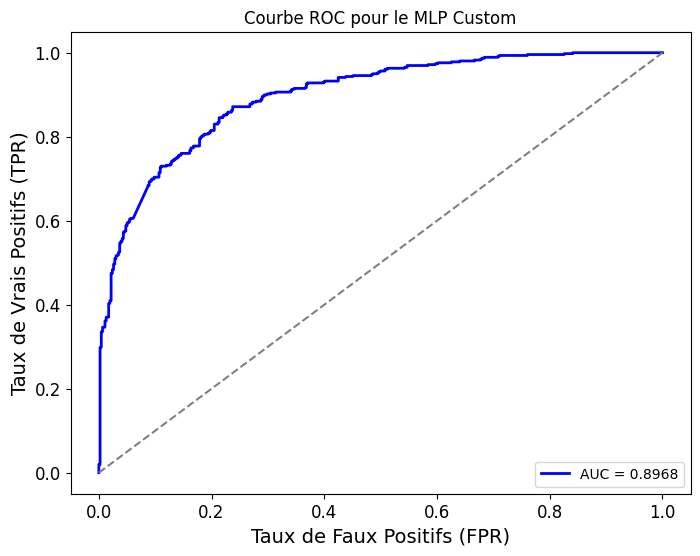

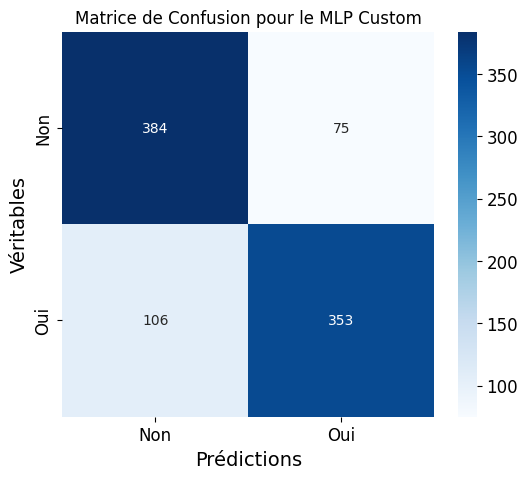

In [44]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Prédictions de probabilités pour la courbe ROC
y_pred_proba_mlp_custom = mlp_custom_model.predict(X_test_scaled).ravel()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_mlp_custom)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC pour le MLP Custom')
plt.legend(loc='lower right')
plt.show()

# Matrice de confusion
y_pred_mlp_custom = (y_pred_proba_mlp_custom > 0.5).astype(int)
conf_matrix_mlp_custom = confusion_matrix(y_test, y_pred_mlp_custom)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_mlp_custom, annot=True, fmt='d', cmap='Blues', xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.title('Matrice de Confusion pour le MLP Custom')
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model_optimized = Sequential([
    Dense(8, activation='relu', input_shape=(3,)),  # 8 neurones au lieu de 4
    Dropout(0.3),  # Ajout de dropout pour la régularisation
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='relu'),  # Ajouter une troisième couche cachée
    Dense(1, activation='sigmoid')  # Probabilité de glissement de terrain
])

# Compilation avec optimiseur et taux d'apprentissage plus avancés
model_optimized.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
from tensorflow.keras.callbacks import EarlyStopping
# Définir l'early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveillance de la perte de validation
    patience=10,         # Nombre d'époques sans amélioration avant d'arrêter
    restore_best_weights=True  # Recharger les poids du meilleur modèle trouvé
)

# 2. Entraînement du modèle
history = model_optimized.fit(X_train_scaled, y_train,
                              epochs=200,  # Ajustable en fonction des besoins
                              batch_size=16,  # Taille du lot pour l'entraînement
                              validation_data=(X_val_scaled, y_val),
                              verbose=1)

Epoch 1/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4947 - loss: 0.6972 - val_accuracy: 0.6458 - val_loss: 0.6604
Epoch 2/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6608 - loss: 0.6453 - val_accuracy: 0.7384 - val_loss: 0.5995
Epoch 3/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7040 - loss: 0.5990 - val_accuracy: 0.7534 - val_loss: 0.5404
Epoch 4/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7194 - loss: 0.5599 - val_accuracy: 0.7629 - val_loss: 0.5160
Epoch 5/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7424 - loss: 0.5388 - val_accuracy: 0.7793 - val_loss: 0.4961
Epoch 6/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7412 - loss: 0.5315 - val_accuracy: 0.7984 - val_loss: 0.4836
Epoch 7/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7671 - loss: 0.5055 - val_accuracy: 0.7956 - val_loss: 0.4734
Epoch 8/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7584 - loss: 0.5095 - val_accu

In [47]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model_optimized.evaluate(X_test_scaled, y_test)
print(f'Loss sur le test : {test_loss:.4f}')
print(f'Accuracy sur le test : {test_accuracy:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8395 - loss: 0.4556
Loss sur le test : 0.4137
Accuracy sur le test : 0.8214


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


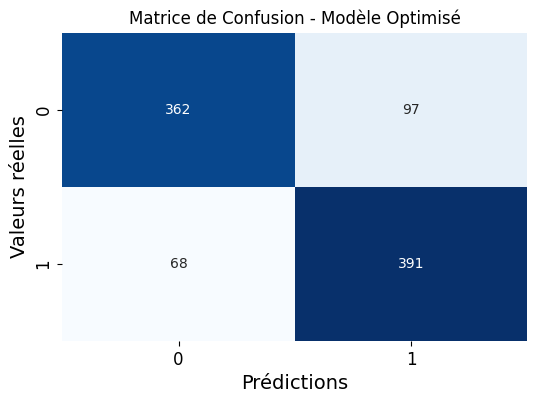

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       459
           1       0.80      0.85      0.83       459

    accuracy                           0.82       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.82      0.82      0.82       918



In [51]:
# 3. Évaluation du modèle optimisé
# Prédiction des probabilités et des classes
y_pred_proba = model_optimized.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.45).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec étiquettes
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de Confusion - Modèle Optimisé")
plt.show()

# Rapport de classification pour des métriques supplémentaires
print("Rapport de Classification :")
print(classification_report(y_test, y_pred))

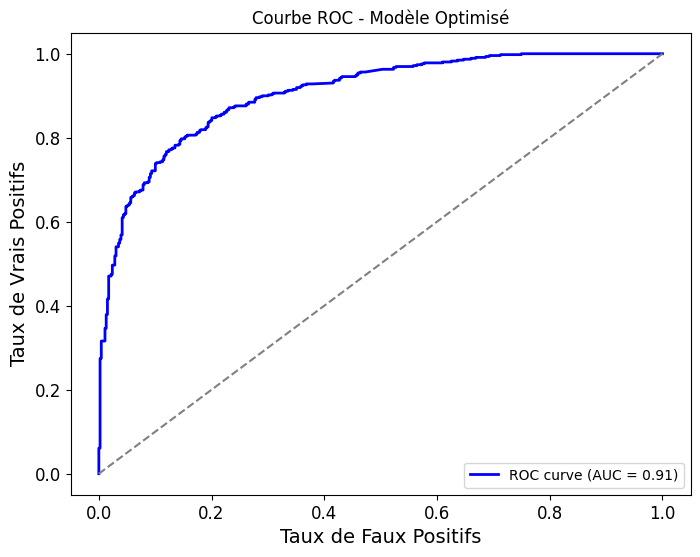

In [52]:
# Courbe ROC et calcul de l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Modèle Optimisé")
plt.legend(loc="lower right")
plt.show()

In [56]:
from tensorflow.keras import regularizers

# Modèle plus complexe avec dropout et régularisation L2
model_complex = Sequential([
    Dense(8, activation="relu", input_shape=(3,), kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(4, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation="sigmoid")
])

# Compilation
model_complex.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Entraînement
history_complex = model_complex.fit(X_train_scaled, y_train, epochs=50, batch_size=16,
                                    validation_data=(X_val_scaled, y_val))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5755 - loss: 0.8232 - val_accuracy: 0.7234 - val_loss: 0.7460
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6672 - loss: 0.7369 - val_accuracy: 0.7398 - val_loss: 0.6783
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7168 - loss: 0.6883 - val_accuracy: 0.7684 - val_loss: 0.6284
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7483 - loss: 0.6313 - val_accuracy: 0.7738 - val_loss: 0.5931
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7425 - loss: 0.6158 - val_accuracy: 0.7834 - val_loss: 0.5641
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7549 - loss: 0.5867 - val_accuracy: 0.8025 - val_loss: 0.5441
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7434 - loss: 0.5742 - val_accuracy: 0.7929 - val_loss: 0.5315
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7633 - loss: 0.5448 - val_accuracy: 0.

In [57]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model_complex.evaluate(X_test_scaled, y_test)
print(f'Loss sur le test : {test_loss:.4f}')
print(f'Accuracy sur le test : {test_accuracy:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8015 - loss: 0.4632 
Loss sur le test : 0.4604
Accuracy sur le test : 0.8061


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


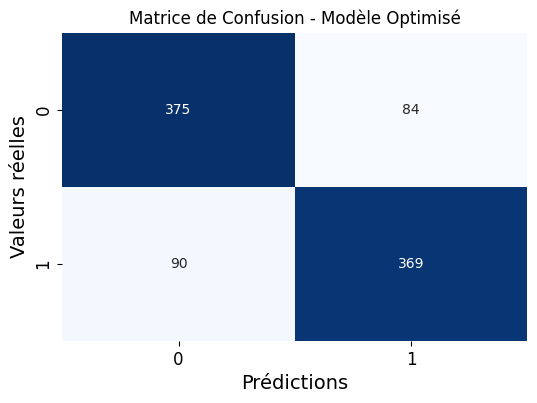

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       459
           1       0.81      0.80      0.81       459

    accuracy                           0.81       918
   macro avg       0.81      0.81      0.81       918
weighted avg       0.81      0.81      0.81       918



In [58]:
# 3. Évaluation du modèle optimisé
# Prédiction des probabilités et des classes
y_pred_proba = model_complex.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.45).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec étiquettes
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de Confusion - Modèle Optimisé")
plt.show()

# Rapport de classification pour des métriques supplémentaires
print("Rapport de Classification :")
print(classification_report(y_test, y_pred))

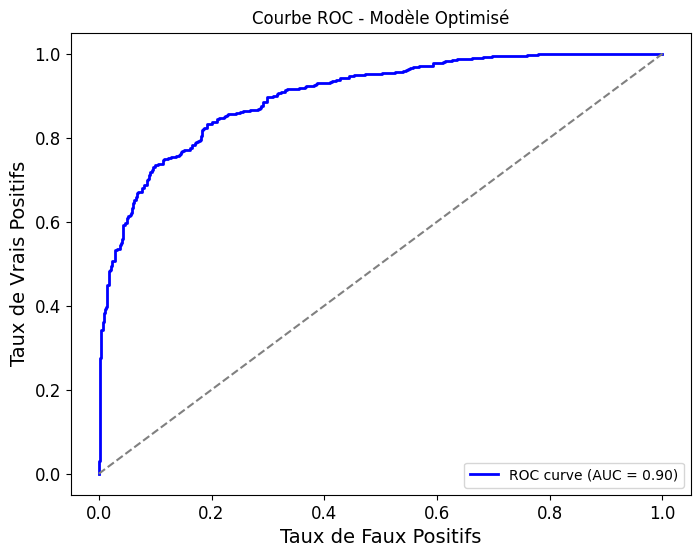

In [59]:
# Courbe ROC et calcul de l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Modèle Optimisé")
plt.legend(loc="lower right")
plt.show()

On voit bien que le modèle optimisé est bien mieux que le simple modèle des italiens, par contre on voit aussi que le modèle complexe que l'on a créé dernièrement n'améliore pas du tout les performances

In [64]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

# Evaluation initiale du modèle
y_pred_initial = (model_optimized.predict(X_test_scaled) > 0.5).astype(int)
initial_accuracy = accuracy_score(y_test, y_pred_initial)

# Initialisation d'un dictionnaire pour stocker les baisses de précision
importances = {}

# Boucle sur chaque colonne pour mesurer l'importance de la variable
for i in range(X_test_scaled.shape[1]):
    X_permuted = X_test_scaled.copy()
    # Permuter la colonne i
    np.random.shuffle(X_permuted[:, i])
    # Prédictions avec la colonne permutée
    y_pred_permuted = (model_optimized.predict(X_permuted) > 0.5).astype(int)
    # Calcul de la nouvelle précision
    permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
    # Importance = dégradation de la précision
    importances[i] = initial_accuracy - permuted_accuracy

# Affichage de l'importance en pourcentage
for i, importance in importances.items():
    print(f"Importance de la variable {i+1} : {importance * 100:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Importance de la variable 1 : 1.31%
Importance de la variable 2 : 12.75%
Importance de la variable 3 : 23.53%


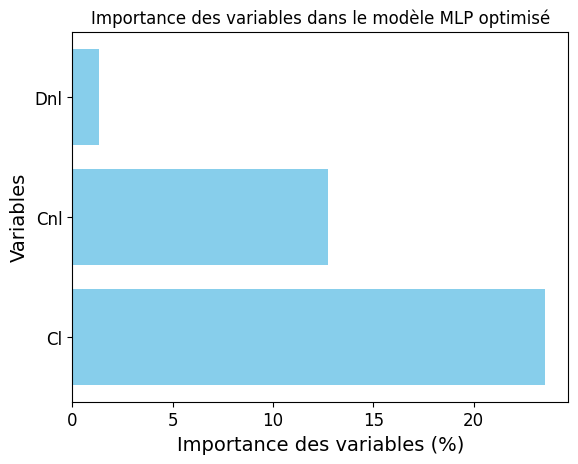

In [66]:
import matplotlib.pyplot as plt

# Conversion du dictionnaire en liste triée pour les graphiques
features = ['Dnl', 'Cnl', 'Cl']
importances_values = [importances[i] * 100 for i in range(len(features))]

plt.barh(features, importances_values, color="skyblue")
plt.xlabel("Importance des variables (%)")
plt.ylabel("Variables")
plt.title("Importance des variables dans le modèle MLP optimisé")
plt.gca().invert_yaxis()  # Inverser l'ordre pour avoir la variable la plus importante en haut
plt.show()
